In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline  

def create_paired_dataset(input_file, output_file=None, label=None):
    # Load the original matrix
    x = np.load(input_file)
    if label == 0:
        y = np.zeros(x.shape[0], dtype=int)
    elif label == 1:
        y = np.ones(x.shape[0], dtype=int)
    
    # Create the paired dataset
    paired_dataset = (x, y)
    
    # Optionally save the paired dataset
    if output_file:
        np.save(output_file, paired_dataset)
    
    return paired_dataset

## Load datasets

In [2]:
layer = 17
cautious_x, cautious_y = create_paired_dataset(f"../activations/baseline/deepseek_layer_{layer}_cautious_activations.npy", label=0)
non_cautious_x, non_cautious_y = create_paired_dataset(f"../activations/baseline/deepseek_layer_{layer}_noncautious_activations.npy", label=1)


## Create train-test sets for logistic classfier

In [3]:
X = np.vstack((cautious_x, non_cautious_x))
y = np.concatenate((cautious_y, non_cautious_y))

# Create a permutation of indices
shuffle_indices = np.random.permutation(len(y))
# Use these indices to shuffle both X and y in the same way
X = X[shuffle_indices]
y = y[shuffle_indices]

print(X)
print(y)

# 5. Split into train and test sets (75% train, 25% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"Feature vector size: {X_train.shape[1]} dimensions")
print(f"Class distribution in training: {np.bincount(y_train)}")
print(f"Class distribution in testing: {np.bincount(y_test)}")

[[ 0.1281329   0.14144562 -0.04362596 ...  0.13630731 -0.00165971
  -0.11208256]
 [-0.04212368  0.06256121  0.23502895 ... -0.0850709  -0.23537217
   0.24752621]
 [-0.05307412  0.04098011  0.25112468 ... -0.09050523 -0.16768251
   0.16486108]
 ...
 [-0.02098154  0.2392397   0.13088301 ...  0.01711768 -0.02745242
   0.0005761 ]
 [-0.10259645  0.06767514  0.3717044  ... -0.14408097 -0.0789308
   0.22295496]
 [-0.04008477  0.04052616  0.24641454 ... -0.10053658 -0.19253132
   0.21107344]]
[0 1 0 1 0 0 0 1 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 1 1 0 1 0 0 1 0 1 1 1 0
 0 1 0 0 1 0 1 0 0 1 1 1 0 1 0 0 0 1 0 0 0 1 0 0 1 1 0 1 1 1 0 1 0 0 0 0 1
 0 0 1 0 0 1 0 1 1 0 0 1 0 0 0 0 1 1 0 0 0 1 1 0 1 0 0 1 0 1 0 0 1 1 1 1 1
 1 1 0 0 1 0 1 1 1 0 1 0 0 1 0 0 0 1 1 0 0 0 1 1 0 0 0 1 1 1 1 0 1 1 0 0 1
 0 1 1 0 1 0 1 0 1 0 1 0 0 1 1 1 1 1 0 0 1 1 1 0 1 0 0 0 0 1 0 1 0 1 1 1 0
 1 1 0 0 1 1 1 1 1 0 1 1 0 0 0 0 1 1 1 1 1 1 1 0 1 0 0]
Training set size: 159 samples
Test set size: 53 samples
Feature vector size: 

## Train a logistic classfier


Accuracy: 0.6792

Classification Report:
              precision    recall  f1-score   support

Non-Cautious       0.73      0.59      0.65        27
    Cautious       0.65      0.77      0.70        26

    accuracy                           0.68        53
   macro avg       0.69      0.68      0.68        53
weighted avg       0.69      0.68      0.68        53



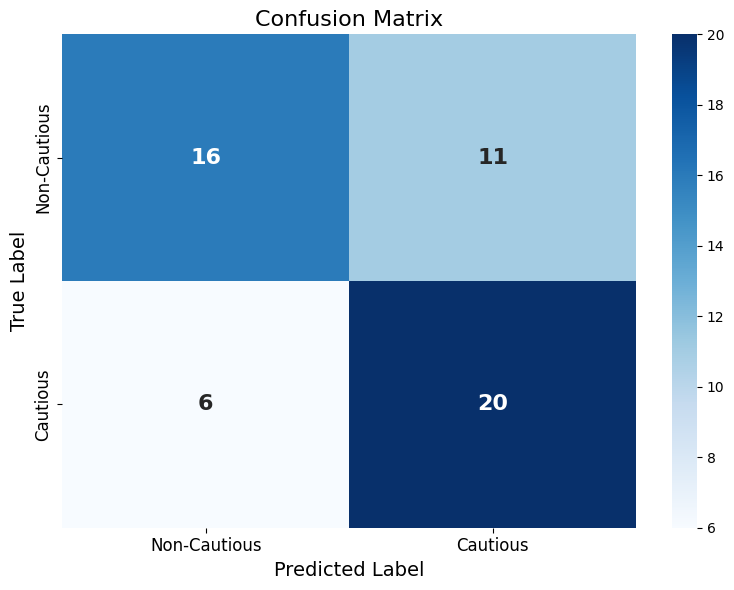

In [4]:
# Train a logistic regression classifier
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train, y_train)

# Evaluate the model
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Non-Cautious", "Cautious"]))

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=["Non-Cautious", "Cautious"],
            yticklabels=["Non-Cautious", "Cautious"],
            annot_kws={"size": 16, "weight": "bold"})
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.title("Confusion Matrix", fontsize=16)

# Increase tick label font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.savefig(f"../figures/confusion_matrix_{layer}_baseline.png")
plt.show()

# #  Feature importance analysis
# if X_train.shape[1] < 20:  # Only show importance if we have few features
#     importance = np.abs(clf.coef_[0])
#     feature_names = [f"Feature {i}" for i in range(X_train.shape[1])]
    
#     # Plot feature importance
#     plt.figure(figsize=(10, 6))
#     features_df = pd.DataFrame({'feature_names': feature_names, 'importance': importance})
#     features_df = features_df.sort_values('importance', ascending=False)
    
#     sns.barplot(x='importance', y='feature_names', data=features_df[:10])  # Top 10 features
#     plt.title('Top 10 Feature Importance for Cautious vs Non-Cautious Classification')
#     plt.tight_layout()
#     plt.savefig("../figures/feature_importance.png")
#     plt.show()
# else:
#     # If too many features, just print top 10 most important
#     importance = np.abs(clf.coef_[0])
#     top_indices = importance.argsort()[-10:][::-1]
#     print("\nTop 10 most important features (by coefficient magnitude):")
#     for i, idx in enumerate(top_indices):
#         print(f"Rank {i+1}: Feature {idx} (Coefficient: {clf.coef_[0][idx]:.4f})")


## Optional

In [15]:
# # Save the trained model (optional)
# import joblib
# joblib.dump(clf, 'cautious_classifier.pkl')
# print("\nModel saved as 'cautious_classifier.pkl'")

